In [1]:
import pandas as pd
from scipy.optimize import fsolve
import numpy as np
import itertools
import copy
from cyipopt import minimize_ipopt
import warnings
import matplotlib.pyplot as plt
from jax.config import config
# Enable 64 bit floating point precision
config.update("jax_enable_x64", True)

# We use the CPU instead of GPU und mute all warnings if no GPU/TPU is found.
config.update('jax_platform_name', 'cpu')

# import jax.numpy as np
from jax import jit, grad, jacfwd, jacrev

In [2]:
def counted(f):
    def wrapped(*args, **kwargs):
        wrapped.calls += 1
        return f(*args, **kwargs)
    wrapped.calls = 0
    return wrapped

Проблемы: надо посчитать долю наследства
Для мигрантов матрицу размера 10к? (Каждое новое поколение имеет другое богатство)

In [691]:
# class OLG_model:
#     def __init__(self, G,T,N,epsilon, rho, sigma,Pi,r,price_M, price_E, tau_I,tau_Ins, tau_pi, tau_VA, tau_rho, beta, phi , theta , psi, omega, alpha, delta, A,initial, eta,steady_max_iter,steady_guess):
#         """
#         OLG model
#         :param G: number of generations, default is 110
#         :param T: simulation time, default is 500
#         :param N_female: population (G+T-1, T) matrix where N[g,t] is cohort size of generation g in period t
#         :param N_male: population (G+T-1, T) matrix where N[g,t] is cohort size of generation g in period t
#         :param epsilon_female: female cohort- and year-specific productivity
#         :param epsilon_male: male cohort- and year-specific productivity
#         :param rho_female: female cohort- and year-specific retirement rate
#         :param rho_male: male cohort- and year-specific retirement rate
#         :param sigma: pension rate (pension point value) for T periods
#         :param Pi_female: survival probability
#         :param Pi_male: survival probability
#         :param Beq_female_to_female,Beq_female_to_male,Beq_male_to_female,Beq_male_to_male: bequest matrix
#         :param r: rate of return for T periods
#         :param price_M: import prices for T periods
#         :param price_E: export prices for T periods
#         :param tau_I: income tax for T periods
#         :param tau_Ins: insurance tax for T periods
#         :param tau_pi: profit tax for T periods
#         :param tau_VA: value-added tax for T periods
#         :param tau_rho: retirement tax for T periods
#         :param beta: elasticity of intertemporal substitution
#         :param phi: elasticity of intertemporal substitution
#         :param theta: ?
#         :param psi: ? investment cost
#         :param omega: import share
#         :param alpha: elasticity of capital
#         :param delta: deprecation rate
#         :param A_N: total factor productivity, non-export good
#         :param A_E: total factor productivity, export goods
#         """

#         ## Exogenous variables and parameters
#         # Demography
#         self.G, self.T,self.N,self.epsilon,self.Pi = G, T,N,epsilon,Pi
#         # Retirement
#         self.rho,self.sigma = rho, sigma
#         # Prices
#         self.r, self.price_M, self.price_E, self.omega = r, price_M, price_E, omega
#         # Taxation
#         self.tau_I, self.tau_pi, self.tau_VA,self.tau_Ins, self.tau_rho =  tau_I, tau_pi,tau_VA,tau_Ins, tau_rho
#         # Utility
#         self.beta, self.phi, self.theta  = beta, phi, theta
#         # Production
#         self.psi, self.alpha, self.delta, self.A = psi, alpha, delta, A

#         self.a_initial = initial["a"]



#         self.eta = eta
#         self.steady_max_iter = steady_max_iter

#         # Endogenous variable
#         # Initial guess
#         self.price_N = np.array([initial["price_N"] for _ in range(max_time)])
#         self.K = np.array([[initial["K_N"] for _ in range(max_time)], [initial["K_E"] for _ in range(max_time)]])
#         self.L = np.array([[initial["L_N"] for _ in range(max_time)], [initial["L_E"] for _ in range(max_time)]])
#         self.I = np.array([[initial["I_N"] for _ in range(max_time)], [initial["I_E"] for _ in range(max_time)]])
#         self.Gov = np.array([initial["Gov"] for _ in range(max_time)])

#         self.lmbda = np.array([[0.5 for _ in range(max_time)] for _ in range(2)])

#         self.w = ((self.price_N *(1-self.alpha)*(self.K[0])**self.alpha *(self.A[0])**(1-self.alpha)*(self.L[0])**(-self.alpha))+
#         (self.price_E *(1-self.alpha)*(self.K[1])**self.alpha *(self.A[1])**(1-self.alpha)*(self.L[1])**(-self.alpha)))/2

#         self.price = (self.price_M)**self.omega * (self.price_N)**(1-self.omega)


#         self.Y = self.K**self.alpha * (self.L*self.A)**(1-self.alpha)


#         self.D = self.Y[0]/(1-self.omega)* self.price_N/self.price + self.Gov

#         self.M = self.omega * self.D * self.price / self.price_M



#         self.c =  np.array([[[0.002 if ((g >= t) and (g<=self.G+t-1)) else 0 for t in range(max_time)] for g in range(max_time)] for _ in range(2)])
#         self.a = np.array([[[0.01 if ((g >= t) and (g<=self.G+t-1)) else 0 for t in range(max_time)] for g in range(max_time)] for _ in range(2)])
#         self.gamma = np.array([[[0.9 if ((g >= t) and (g<=self.G+t-1)) else 0 for t in range(max_time)] for g in range(max_time)] for _ in range(2)])
#         self.l = np.array([[[0.4 if ((g >= t) and (g<=self.G+t-1)) else 0 for t in range(max_time)] for g in range(max_time)] for _ in range(2)])

#         Consumption = np.array([np.sum([self.c[s,g,t]*self.N[s,g,t] for g in range(max_time) for s in range(2)]) for t in range(max_time)])
#         self.Consumption = Consumption

#         Labor = np.array([np.sum([self.l[s,g,self.T]*self.N[s,g,self.T]*self.epsilon[s,g,self.T] for g in range(max_time) for s in range(2)]) for t in range(max_time)])
#         self.Labor = Labor

#         Assets =  np.array([np.sum([self.a[s,g,t]*self.N[s,g,t] for g in range(max_time) for s in range(2)]) for t in range(max_time)])
#         self.Assets = Assets


#         self.steady = np.array(list(steady_guess) + [Consumption[self.T], Labor[self.T], Assets[self.T]])
#         self.steady_path = []

#         self.steady_error = [0,0]
#         self.steady_eta = [0.1, 0.1]



#     def household(self, s, g, t):
#         def labor_income_vector(self, s, g, start, end):
#             return (1-self.tau_I[start:end]) * (1-(self.tau_rho[start:end] + self.tau_Ins[start:end])/(1+self.tau_rho[start:end] + self.tau_Ins[start:end])) * self.epsilon[s,g,start:end] * self.w[start:end]
#         def cumulative_rate_of_return(self,start, end):
#             if start <= end:
#                 return np.prod(1+self.r[start:end]*(1-self.tau_I[start:end]))
#             else:
#                 return 1

#         def get_initial_consumption(self, s, g, t_0):
#             return self.phi * (self.a_initial[s,g] * cumulative_rate_of_return(self, t_0, g+1)+
#                                np.sum(np.array([cumulative_rate_of_return(self,start, g+1) for start in range(t_0+1, g+2)])*
#                                       (labor_income_vector(self, s, g, t_0, g+1)+self.rho[s,g,t_0:(g+1)]*self.sigma[t_0:(g+1)]
#                                        )))/\
#                    np.sum(
#                        np.array([cumulative_rate_of_return(self,start, g+1) for start in range(t_0+1, g+2)])*
#                        (1+self.tau_VA[t_0:(g+1)])*(self.price[t_0:(g+1)])*
#                        (
#                                np.array([cumulative_rate_of_return(self,t_0+1, end) for end in range(t_0+1, g+2)])*
#                                self.beta**np.array([i-t_0 for i in range(t_0, g+1)])*self.Pi[s,g,t_0:(g+1)]/self.Pi[s,g,t_0] * (1+self.tau_VA[t_0])*(self.price[t_0])/((1+self.tau_VA[t_0:(g+1)])*(self.price[t_0:(g+1)])) *
#                                ((1+self.tau_VA[t_0:(g+1)])*(self.price[t_0:(g+1)])/((1+self.tau_VA[t_0])*self.price[t_0])*labor_income_vector(self, s, g,t_0, t_0+1)/labor_income_vector(self, s, g,t_0, g+1)
#                                 )**((1-self.phi)*(1-self.theta)))**(1/self.theta)
#                    )
#         t_0 = max(g-self.G+1,0)
#         bequest = 0
#         if t==t_0:
#             consumption = get_initial_consumption(self, s, g, t_0)
#         elif t_0 < t <= g:
#             consumption = self.c[s, g, t_0]*\
#                           (cumulative_rate_of_return(self, t_0+1, t+1)*
#                            self.beta**(t-t_0)*self.Pi[s,g,t]/self.Pi[s,g,t_0] * (1+self.tau_VA[t_0])*self.price[t_0]/((1+self.tau_VA[t])*self.price[t]) *
#                            ((1+self.tau_VA[t])*self.price[t]/((1+self.tau_VA[t_0])*self.price[t_0])*labor_income_vector(self, s, g,t_0, t_0+1)/labor_income_vector(self, s, g,t, t+1))**((1-self.phi)*(1-self.theta))
#                            )**(1/self.theta)


#         labor = 1- consumption/(self.phi/(1-self.phi)*(1/((1+self.tau_VA[t])*self.price[t]))*labor_income_vector(self, s, g, t, t+1)[0])
#         if t == 0:
#             assets = labor_income_vector(self, s, g, t, t+1)[0]*labor+self.rho[s,g,t]*self.sigma[t] - consumption*(1+self.tau_VA[t])*self.price[t]+self.a_initial[s,g]*(1+self.r[t]*(1-self.tau_I[t]))
#         else:
#             assets = labor_income_vector(self, s, g, t, t+1)[0]*labor+self.rho[s,g,t]*self.sigma[t] - consumption*(1+self.tau_VA[t])*self.price[t]+(self.a[s,g, t-1]+bequest)*(1+self.r[t]*(1-self.tau_I[t]))
#         return consumption, labor, assets

#     @counted
#     def steady_state(self):
#         def labor_income_vector(self, s, g, start, end):
#             return (1-self.tau_I[start:end]) * (1-(self.tau_rho[start:end] + self.tau_Ins[start:end])/(1+self.tau_rho[start:end] + self.tau_Ins[start:end])) * self.epsilon[s,g,start:end] * self.w[start:end]
#         A_growth = self.A[0,self.T]/self.A[0, self.T-1]
#         N_growth = np.sum([self.N[s,g,self.T]*self.epsilon[s,g,self.T] for g in range(self.T, self.G+self.T) for s in range(2)])/\
#                    np.sum([self.N[s,g,self.T-1]*self.epsilon[s,g,self.T-1] for g in range(self.T-1, self.G+self.T-1) for s in range(2)])

#         w_steady, price_steady, price_N_steady = self.steady[7:10]

#         for t in range(self.T-self.G + 1, max_time):
#             self.w[t] = w_steady* A_growth**(t - self.T)
#             self.price[t] = price_steady
#             self.price_N[t] = price_N_steady

#         for s in range(2):
#             initial_household = self.household(s, self.G+self.T-1, self.T) # первое родившееся поколение в период self.T
#             self.c[s, self.G+self.T-1, self.T],self.l[s, self.G+self.T-1,self.T],self.a[s, self.G+self.T-1,self.T] = initial_household
#             for t in range(self.T,self.G+self.T):
#                 self.c[s, self.G+self.T-1, t],self.l[s, self.G+self.T-1,t],self.a[s, self.G+self.T-1,t] = self.household(s, self.G+self.T-1, t)
#             for g in range(self.G+self.T-2, self.T-1, -1): # все поколения, живущие в периоде self.T

#                 self.c[s, g, g-self.G + 1]  = initial_household[0] * A_growth**(self.G+self.T-1 - g)
#                 self.l[s, g, g-self.G + 1]  = initial_household[1]
#                 self.a[s, g,g-self.G + 1]  = labor_income_vector(self, s, g,g-self.G + 1, g-self.G + 2)[0]*self.l[s, g, g-self.G + 1]+self.rho[s,g,g-self.G + 1]*self.sigma[g-self.G + 1] - self.c[s, g, g-self.G + 1]*(1+self.tau_VA[g-self.G + 1])*self.price[g-self.G + 1]
#                 for t in range(g-self.G + 2, g+1):
#                     self.c[s, g, t],self.l[s, g, t],self.a[s, g, t] =  self.household(s, g, t)
#         Consumption = np.sum([self.c[s,g,self.T]*self.N[s,g,self.T] for g in range(self.T, self.G+self.T) for s in range(2)])

#         Labor = np.sum([self.l[s,g,self.T]*self.N[s,g,self.T]*self.epsilon[s,g,self.T] for g in range(self.T, self.G+self.T) for s in range(2)])

#         Assets =  np.sum([self.a[s,g,self.T]*self.N[s,g,self.T] for g in range(self.T, self.G+self.T) for s in range(2)])

#         if len(self.steady_path)==0:
#             self.steady[10:13] = np.array([Consumption,  Labor, Assets])
#         else:
#             self.steady[10:13] = self.eta*np.array([Consumption,  Labor, Assets]) + (1-self.eta)*self.steady[10:13]
# #         self.steady[10:13] = np.array([Consumption,  Labor, Assets])

#         z_guess = self.steady[:10]
        
#         def equilibrium(z, self=self, objective = True):

#             A_growth = self.A[0,self.T]/self.A[0, self.T-1]
#             N_growth = np.sum([self.N[s,g,self.T]*self.epsilon[s,g,self.T] for g in range(self.T, self.G+self.T) for s in range(2)])/\
#                        np.sum([self.N[s,g,self.T-1]*self.epsilon[s,g,self.T-1] for g in range(self.T-1, self.G+self.T-1) for s in range(2)])


#             system = [f"{1-self.alpha}*price_N_steady * (K_N_steady)**{self.alpha} *{(self.A[0,self.T])**(1-self.alpha)}*  (L_N_steady)**({-self.alpha}) - w_steady",
#                       f"price_steady - lmbda_steady *(1 - {self.psi/2} * ({A_growth*N_growth} -1)**2 - {self.psi}*{A_growth*N_growth} * ({A_growth*N_growth -1}))-{self.psi/(1+self.r[self.T+1])}*lmbda_steady  * ({A_growth*N_growth} -1)* ({A_growth*N_growth})**2",
#                       f"{1/(1+self.r[self.T+1])}*(({1-self.tau_pi[self.T+1]}) *{self.alpha}*price_N_steady* (K_N_steady)**{self.alpha-1} * ({self.A[0,self.T]} *L_N_steady)**{1-self.alpha}+{self.tau_pi[self.T+1]} * {self.delta} * price_steady + lmbda_steady * ({1-self.delta})) - lmbda_steady",
#                       f"({1-self.delta})* K_N_steady + I_N_steady*(1-{self.psi/2}*({A_growth*N_growth} -1)**2) - K_N_steady*{A_growth*N_growth}",
#                       f"{1-self.alpha}*{self.price_E[self.T]} * (K_E_steady)**{self.alpha} *{(self.A[0,self.T])**(1-self.alpha)}*  (L_E_steady)**({-self.alpha}) - w_steady",
#                       f"{1/(1+self.r[self.T+1])}*(({1-self.tau_pi[self.T+1]}) *{self.alpha}* {self.price_E[self.T+1]}* (K_E_steady)**{self.alpha-1} * ({self.A[1,self.T]} *L_E_steady)**{1-self.alpha}+{self.tau_pi[self.T+1]} * {self.delta} * price_steady + lmbda_steady * ({1-self.delta})) - lmbda_steady",
#                       f"({1-self.delta})* K_E_steady + I_E_steady*(1-{self.psi/2}*({A_growth*N_growth} -1)**2) - K_E_steady*{A_growth*N_growth}"
#                       , f"L_N_steady+L_E_steady - {self.steady[11]}"
#                       ,f"price_N_steady*(K_N_steady**{self.alpha} * ({self.A[0, self.T]}*L_N_steady)**({1-self.alpha}) -{self.Gov[self.T]})- (1-{self.omega}) * price_steady * ({self.steady[10]}+I_N_steady+I_E_steady)"
#                       ,f"price_steady - {self.price_M[self.T]**self.omega}*price_N_steady**({1-self.omega})"
#                       ]
#             name_space = {label:value for label, value in zip(("self","I_N_steady", "K_N_steady", "L_N_steady", "I_E_steady", "K_E_steady", "L_E_steady","lmbda_steady", "w_steady", "price_steady", "price_N_steady"),[self]+list(z))}

#             if objective:
#                 sum_of_squares = "+".join([f"({equation})**2" for equation in system])
#                 F = eval(sum_of_squares,{},name_space)
#             else:
#                 F = [eval(equation,{},name_space) for equation in system]
#             return F
#         def equilibrium_gradient(z, self=self, objective = True):

#             A_growth = self.A[0,self.T]/self.A[0, self.T-1]
#             N_growth = np.sum([self.N[s,g,self.T]*self.epsilon[s,g,self.T] for g in range(self.T, self.G+self.T) for s in range(2)])/\
#                        np.sum([self.N[s,g,self.T-1]*self.epsilon[s,g,self.T-1] for g in range(self.T-1, self.G+self.T-1) for s in range(2)])

#             gradient = [
#                 # "I_N_steady"
#                 ["0",
#                          "0",
#                          "0",
#                          f"(1-{self.psi/2}*({A_growth*N_growth} -1)**2)",
#                          "0",
#                          "0"
#                          ,"0"
#                          ,"0"
#                          ,f"({1-self.omega}) * price_steady"
#                          ,"0"
#                 ],
#                         # "K_N_steady"
#                         [f"{1-self.alpha}*{self.alpha}*price_N_steady * K_N_steady**{self.alpha-1} *{(self.A[0,self.T])**(1-self.alpha)}* L_N_steady**{-self.alpha}",
#                          "0",
#                          f"{1/(1+self.r[self.T+1])}*({1-self.tau_pi[self.T+1]} *{self.alpha}*{self.alpha-1}* price_N_steady* (K_N_steady)**{self.alpha-2} * ({self.A[0,self.T]} *L_N_steady)**{1-self.alpha})",
#                          f"{1-self.delta} - {A_growth*N_growth}",
#                          "0",
#                          "0",
#                          "0"
#                          ,"0"
#                          ,f"price_N_steady*{self.alpha}*K_N_steady**{self.alpha-1} * ({self.A[0, self.T]}*L_N_steady)**{1-self.alpha}"
#                          ,"0"
#                         ],
#                         # "L_N_steady"
#                         [
#                             f"price_N_steady *{1-self.alpha} * (K_N_steady)**{self.alpha} *{(self.A[0,self.T])**(1-self.alpha)}*{-self.alpha} *(L_N_steady)**{-self.alpha-1}",
#                             "0",
#                             f"""{1/(1+self.r[self.T+1])}*{1-self.tau_pi[self.T+1]} *{self.alpha}* price_N_steady*(K_N_steady)**{self.alpha-1} *({self.A[0,self.T]})**{1-self.alpha} *{1-self.alpha}*L_N_steady**{-self.alpha}""",
#                             "0",
#                             "0",
#                             "0",
#                             "0"
#                             ,"1"
#                             ,f"price_N_steady*K_N_steady**{self.alpha} * ({self.A[0, self.T]})**{1-self.alpha}*{1-self.alpha}*L_N_steady**{-self.alpha}"
#                             ,"0"
#                         ],
#                         # I_E_steady
#                         ["0",
#                          "0",
#                          "0",
#                          "0",
#                          "0",
#                          "0",
#                          f"(1-{self.psi/2}*({A_growth*N_growth} -1)**2)"
#                          ,"0"
#                          ,f"({1-self.omega}) * price_steady"
#                          ,"0"
#                         ],
#                         # K_E_steady
#                         ["0",
#                          "0",
#                          "0",
#                          "0",
#                          f"{1-self.alpha}*{self.alpha}*{self.price_E[self.T]} * K_E_steady**{self.alpha-1} *{(self.A[1,self.T])**(1-self.alpha)}* L_E_steady**{-self.alpha}",
#                          f"{1/(1+self.r[self.T+1])}*({1-self.tau_pi[self.T+1]} *{self.alpha}*{self.alpha-1}* {self.price_E[self.T]}* (K_E_steady)**{self.alpha-2} * ({self.A[1,self.T]} *L_E_steady)**{1-self.alpha})",
#                          f"{1-self.delta} - {A_growth*N_growth}"
#                          ,"0"
#                          ,"0"
#                          ,"0"
#                         ],
#                         # L_E_steady
#                         ["0",
#                          "0",
#                          "0",
#                          "0",
#                         f"{self.price_E[self.T]} *{1-self.alpha} * (K_E_steady)**{self.alpha} *{(self.A[1,self.T])**(1-self.alpha)}*{-self.alpha} *(L_E_steady)**{-self.alpha-1}",
#                         f"""{1/(1+self.r[self.T+1])}*{1-self.tau_pi[self.T+1]} *{self.alpha}* {self.price_E[self.T]}*(K_E_steady)**{self.alpha-1} *({self.A[1,self.T]})**{1-self.alpha} *{1-self.alpha}*L_E_steady**{-self.alpha}""",
#                         "0"
#                         ,"1"
#                         ,"0"
#                         ,"0"
#                         ],
#                         # lmbda_steady
#                         ["0",
#                          f"-(1 - {self.psi/2} * ({A_growth*N_growth} -1)**2 - {self.psi}*{A_growth*N_growth} * ({A_growth*N_growth} -1))-{self.psi/(1+self.r[self.T+1])}* ({A_growth*N_growth} -1)* {A_growth*N_growth}**2",
#                          f"{1/(1+self.r[self.T+1])}*{1-self.delta} - 1",
#                          "0",
#                          "0",
#                          f"{1/(1+self.r[self.T+1])}*{1-self.delta} - 1",
#                          "0"
#                          ,"0"
#                          ,"0"
#                          ,"0"
#                         ],
#                         # w_steady
#                         ["-1",
#                          "0",
#                          "0",
#                          "0",
#                          "-1",
#                          "0",
#                          "0"
#                          ,"0"
#                          ,"0"
#                          ,"0"
#                         ],
#                         # price_steady
#                         ["0",
#                          "1",
#                          f"{1/(1+self.r[self.T+1])}*{self.tau_pi[self.T+1]} * {self.delta}",
#                          "0",
#                          "0",
#                          f"{1/(1+self.r[self.T+1])}*{self.tau_pi[self.T+1]} * {self.delta}",
#                          "0"
#                          ,"0"
#                          ,f"-(1-{self.omega}) * ({self.steady[10]}+I_N_steady+I_E_steady)"
#                          ,"1"
#                          ],
#                         # price_N_steady
#                         [f"{1-self.alpha}*(K_N_steady)**{self.alpha} *{(self.A[0,self.T])**(1-self.alpha)}*  (L_N_steady)**({-self.alpha})",
#                          "0",
#                          f"{1/(1+self.r[self.T+1])}*({1-self.tau_pi[self.T+1]}) *{self.alpha}* (K_N_steady)**{self.alpha-1} * ({self.A[0,self.T]} *L_N_steady)**{1-self.alpha}",
#                          "0",
#                          "0",
#                          "0",
#                          "0"
#                          ,"0"
#                          ,f"K_N_steady**{self.alpha} * ({self.A[0, self.T]}*L_N_steady)**({1-self.alpha}) -{self.Gov[self.T]}"
#                          ,f"- {self.price_M[self.T]**self.omega}*{1-self.omega}*price_N_steady**({-self.omega})"
#                          ]]
#             name_space = {label:value for label, value in zip(("self","I_N_steady", "K_N_steady", "L_N_steady","I_E_steady", "K_E_steady", "L_E_steady", "lmbda_steady", "w_steady", "price_steady", "price_N_steady"),[self]+list(z))}
#             if objective:
#                 target_system = equilibrium(z, self, False)
#                 sum_of_gradient = ["+".join([f"2*({outer})*({inner})" for outer, inner in zip(target_system, row)]) for row in gradient]
#                 J = [eval(equation,{},name_space) for equation in sum_of_gradient]
#             else:
#                 J = [[eval(equation,{},name_space) for equation in row] for row in gradient]
#             return J
            
# #         obj_jit = jit(equilibrium)
# #         obj_grad = equilibrium_gradient
# #         obj_hess = jit(jacrev(jacfwd(obj_jit)))
#         def eq_constraints(z, self=self, objective = True):

#             A_growth = self.A[0,self.T]/self.A[0, self.T-1]
#             N_growth = np.sum([self.N[s,g,self.T]*self.epsilon[s,g,self.T] for g in range(self.T, self.G+self.T) for s in range(2)])/\
#                        np.sum([self.N[s,g,self.T-1]*self.epsilon[s,g,self.T-1] for g in range(self.T-1, self.G+self.T-1) for s in range(2)])


#             system = [
#                       f"price_steady - {self.price_M[self.T]**self.omega}*price_N_steady**({1-self.omega})"
# #                       ,f"L_N_steady+L_E_steady - {self.steady[11]}"
# #                       ,f"price_N_steady*(K_N_steady**{self.alpha} * ({self.A[0, self.T]}*L_N_steady)**({1-self.alpha}) -{self.Gov[self.T]})- (1-{self.omega}) * price_steady * ({self.steady[10]}+I_N_steady+I_E_steady)"
#                       ]
#             name_space = {label:value for label, value in zip(("self","I_N_steady", "K_N_steady", "L_N_steady", "I_E_steady", "K_E_steady", "L_E_steady","lmbda_steady", "w_steady", "price_steady", "price_N_steady"),[self]+list(z))}

#             if objective:
#                 sum_of_squares = "+".join([f"({equation})**2" for equation in system])
#                 F = eval(sum_of_squares,{},name_space)
#             else:
#                 F = [eval(equation,{},name_space) for equation in system]
#             return F
        
#         obj_jit = jit(equilibrium)
# #         con_eq_jit = jit(eq_constraints)

#         # build the derivatives and jit them
#         obj_grad = equilibrium_gradient  # objective gradient
#         obj_hess = jit(jacrev(jacfwd(obj_jit)))# objective hessian
        
# #         con_eq_jac = jit(jacfwd(con_eq_jit))  # jacobian
# #         con_eq_hess = jacrev(jacfwd(con_eq_jit)) # hessian
# #         con_eq_hessvp = jit(lambda x, v: con_eq_hess(x) * v[0]) # hessian vector-product
# #         cons = [
# #             {'type': 'eq', 'fun': con_eq_jit, 'jac': con_eq_jac, 'hess': con_eq_hessvp}
# #          ]
        
#         result = minimize_ipopt(obj_jit, jac=obj_grad, hess=obj_hess, x0=z_guess
#                                 , options = {"max_iter":self.steady_max_iter, "print_level":0,
#                                              "check_derivatives_for_naninf":"yes"}
# #                                , constraints = cons
#                                 , tol=1e-7)
        
        
#         if result["success"]:
#             self.steady[:10] = self.eta*result["x"] + (1-self.eta)*z_guess
#             self.steady_max_iter = 1000
#             eq_res = equilibrium(self.steady[:10], self, False)
#         else:
#             if result["status"]==-1:
#                 self.steady_max_iter += 1000
#             self.steady[:10] = z_guess
#             eq_res = equilibrium(z_guess, self, False)
            
# #             labor market
#             if abs(eq_res[7])>10:
#                 sign = np.sign(eq_res[7]) 
#                 if np.sign(self.steady_error[0]) != sign:
#                     self.steady_eta[0] = self.steady_eta[0] / 2
#                 self.steady[7] = (1+self.steady_eta[0])**(sign)*z_guess[7]
            
# #             goods market
# #             if abs(eq_res[8])>10:
# #                 sign = np.sign(eq_res[8]) 
# #                 if np.sign(self.steady_error[1]) != sign:
# #                     self.steady_eta[1] = self.steady_eta[1] / 2
# #                 self.steady[8] = (1+self.steady_eta[1]*2)**(-sign)*z_guess[8]
        
#         self.steady_error = eq_res[7], eq_res[8]
                
#         self.steady_path.append((result, np.array(self.steady)
#                                  ,np.array(self.steady_error)
#                                  ,np.array(self.steady_eta)
#                                ))

#     def create_guess(self):

#         A_growth = self.A[0,self.T]/self.A[0, self.T-1]
#         N_growth = np.sum([self.N[s,g,self.T]*self.epsilon[s,g,self.T] for g in range(self.T, self.G+self.T) for s in range(2)])/\
#                    np.sum([self.N[s,g,self.T-1]*self.epsilon[s,g,self.T-1] for g in range(self.T-1, self.G+self.T-1) for s in range(2)])

#         I_N_steady, K_N_steady, L_N_steady,I_E_steady, K_E_steady, L_E_steady, lmbda_steady, w_steady, price_steady, price_N_steady = self.steady[:10]

#         for t in range(self.T-self.G + 1, max_time):
#             self.w[t] = w_steady* A_growth**(t - self.T)
#             self.price[t] = price_steady
#             self.price_N[t] = price_N_steady

#             self.I[0,t] = I_N_steady*(A_growth*N_growth)**(t - self.T)
#             self.K[0,t] = K_N_steady*(A_growth*N_growth)**(t - self.T)
#             self.L[0,t] = L_N_steady*(N_growth)**(t - self.T)
#             self.lmbda[0,t] = lmbda_steady

#             self.I[1,t] = I_E_steady*(A_growth*N_growth)**(t - self.T)
#             self.K[1,t] = K_E_steady*(A_growth*N_growth)**(t - self.T)
#             self.L[1,t] = L_E_steady*(N_growth)**(t - self.T)
#             self.lmbda[1,t] = lmbda_steady

#         steady_start = self.T-self.G + 1
#         self.price_N[:steady_start] = np.linspace(initial["price_N"], self.price_N[steady_start], steady_start,endpoint=False)
#         self.I[0,:steady_start] = np.linspace(initial["I_N"], self.I[0,steady_start], steady_start,endpoint=False)
#         self.K[0,:steady_start] = np.linspace(initial["K_N"], self.K[0,steady_start], steady_start,endpoint=False)
#         self.L[0,:steady_start] = np.linspace(initial["L_N"], self.L[0,steady_start], steady_start,endpoint=False)
#         # self.lmbda[0,:steady_start] = np.linspace(initial["price_N"], self.lmbda[0,steady_start], steady_start,endpoint=False)

#         self.I[1,:steady_start] = np.linspace(initial["I_E"], self.I[1,steady_start], steady_start,endpoint=False)
#         self.K[1,:steady_start] = np.linspace(initial["K_E"], self.K[1,steady_start], steady_start,endpoint=False)
#         self.L[1,:steady_start] = np.linspace(initial["L_E"], self.L[1,steady_start], steady_start,endpoint=False)
#         # self.lmbda[1,:steady_start] = np.linspace(initial["price_N"], self.lmbda[1,steady_start], steady_start,endpoint=False)


#         self.w[:steady_start] = ((self.price_N[:steady_start] *(1-self.alpha)*(self.K[0,:steady_start])**self.alpha *(self.A[0,:steady_start])**(1-self.alpha)*(self.L[0,:steady_start])**(-self.alpha))+
#               (self.price_E[:steady_start] *(1-self.alpha)*(self.K[1,:steady_start])**self.alpha *(self.A[1,:steady_start])**(1-self.alpha)*(self.L[1,:steady_start])**(-self.alpha)))/2

#         self.price[:steady_start] = (self.price_M[:steady_start])**self.omega * (self.price_N[:steady_start])**(1-self.omega)

#     def update_guess(self):

#         ## Endogenous variables

#         def labor_demand_euler(params, S,  t):
#             if S == 1: # export
#                 sectoral_price = params.price_E[t]
#             elif S==0: # non-export
#                 sectoral_price = f"self.price_N[{t}]"
#             return f"({1-params.alpha})* {sectoral_price} * ({params.K[S,t]})**{params.alpha} *{(params.A[S,t])**(1-params.alpha)}*  (self.L[{S},{t}])**({-params.alpha}) - self.w[{t}]"


#         def investment_euler(params, S, t):
#             return f"self.price[{t}] - self.lmbda[{S},{t}] *(1 - {params.psi/2} * (self.I[{S},{t}]/{params.I[S,t-1]} -1)**2 - {params.psi}*self.I[{S},{t}]/{params.I[S,t-1]} * (self.I[{S},{t}]/{params.I[S,t-1]} -1))-{params.psi/(1+params.r[t+1])}*{params.lmbda[S,t+1]}  * ({params.I[S,t+1]}/self.I[{S},{t}] -1)* ({params.I[S,t+1]}/self.I[{S},{t}])**2"


#         def capital_euler(params, S, t):
#             if S == 1: # export
#                 sectoral_price = params.price_E[t+1]
#             elif S==0: # non-export
#                 sectoral_price = params.price_N[t+1]
#             return f"{1/(1+params.r[t+1])}*(({1-params.tau_pi[t+1]}) *{params.alpha}* {sectoral_price}* (self.K[{S},{t+1}])**{params.alpha-1} * ({params.A[S,t+1]} *{params.L[S,t+1]})**{1-params.alpha}+{params.tau_pi[t+1]} * {params.delta} * {params.price[t+1]} + {params.lmbda[S,t+1]} * ({1-params.delta})) - self.lmbda[{S},{t}]"


#         def capital_accomodation(params, S, t):
#             return f" ({1-params.delta})* {params.K[S,t]} + self.I[{S},{t}]*(1-{params.psi/2}*(self.I[{S},{t}]/{params.I[S,t-1] -1})**2) - self.K[{S},{t+1}]"

#         def labor_market_clearing(params, t):
#             L = np.sum([params.l[s,g,t]*params.N[s,g,t]*params.epsilon[s,g,t] for g in range(t, params.G+t) for s in range(2)])
#             return f"self.L[0,{t}]+self.L[1,{t}] - {L}"

#         def goods_market_clearing(params, t):
#             C = np.sum([params.c[s,g,t]*params.N[s,g,t] for g in range(t, params.G+t) for s in range(2)])
#             return [f"{params.K[0,t]}**{params.alpha} * ({params.A[0, t]}*self.L[{0},{t}])**(1-{params.alpha}) -{params.Gov[t]}- (1-{params.omega}) * self.price[{t}]/self.price_N[{t}] * ({C}+self.I[0,{t}]+self.I[1,{t}])",
#                 f"self.price[{t}] - {params.price_M[t]**params.omega}*self.price_N[{t}]**({1-params.omega})"]

#         def labor_derivative(params, S, t):
#             if S == 1: # export
#                 sectoral_price = params.price_E[t]
#             elif S==0: # non-export
#                 sectoral_price = f"self.price_N[{t}]"
#             nulls = ["0" for _ in range(4)]
#             # порядок: I[S,t], K[S,t+1], L[S, t], lmbda[S,t]

#             derivatives = ["0", "0",
#                     f"""{(-params.alpha)*(1-params.alpha)*(params.A[S,t])**(1-params.alpha)}*{sectoral_price}*{params.K[S,t]}**{params.alpha}*self.L[{S},{t}]**{-1-params.alpha}""", "0"]
#             if S == 1: # export
#                 return nulls+derivatives+["-1"]+["0","0"]
#             elif S==0: # non-export
#                 return derivatives+nulls+["-1"]+[f"""{(1-params.alpha)*(params.A[S,t])**(1-params.alpha)}*{sectoral_price}*{params.K[S,t]}**{params.alpha}*self.L[{S},{t}]**{-params.alpha}""","0"]
#         def investment_derivative(params, S, t):
#             nulls = ["0" for _ in range(4)]

#             derivatives= [
#                 f"- self.lmbda[{S},{t}] *(1 - {params.psi}/{params.I[S,t-1]} * (self.I[{S},{t}]/{params.I[S,t-1]} -1)**2 - {params.psi}/{params.I[S,t-1]} * (self.I[{S},{t}]/{params.I[S,t-1]} -1)- {params.psi}*self.I[{S},{t}]/{params.I[S,t-1]**2})-{params.psi/(1+params.r[t+1])}*{params.lmbda[S,t+1]}  * ({params.I[S,t+1]}**2 * (-2)/self.I[{S},{t}]**3 * ({params.I[S,t+1]}/self.I[{S},{t}] -1)+self.I[{S},{t}]*(-1)/self.I[{S},{t}]**2 * ({params.I[S,t+1]}/self.I[{S},{t}])**2)",
#                     "0",
#                     "0",
#                     f"-  (1 - {params.psi/2} * (self.I[{S},{t}]/{params.I[S,t-1]} -1)**2 - {params.psi}*self.I[{S},{t}]/{params.I[S,t-1]} * (self.I[{S},{t}]/{params.I[S,t-1]} -1))"
#                     ]
#             if S == 1: # export
#                 return nulls+derivatives+["0","0","1"]
#             elif S==0: # non-export
#                 return derivatives+nulls+["0","0","1"]


#         def capital_derivative(params, S, t):
#             if S == 1: # export
#                 sectoral_price = params.price_E[t+1]
#             elif S==0: # non-export
#                 sectoral_price = params.price_N[t+1]
#             nulls = ["0" for _ in range(4)]

#             derivatives = ["0",f"""1/({1+params.r[t+1]}) * {(1-params.tau_pi[t+1])*params.alpha*(params.alpha-1)}*{sectoral_price} * {(params.A[S,t+1])**(1-params.alpha)} * (self.K[{S},{t+1}])**{params.alpha-2} * ({params.L[S,t+1]})**({1-params.alpha})""" ,"0", "-1"]
#             if S == 1: # export
#                 return nulls+derivatives+["0","0","0"]
#             elif S==0: # non-export
#                 return derivatives+nulls+["0","0","0"]

#         def capital_accommodation_derivative(params, S, t):

#             nulls = ["0" for _ in range(4)]
#             derivatives = [f"""((1-{params.psi/2}*(self.I[{S},{t}]/{params.I[S,t-1]} - 1))**2-self.I[{S},{t}] * ({-params.psi}/{params.I[S,t-1]} * (self.I[{S},{t}]/{params.I[S,t-1]} - 1)))""","-1","0","0"]
#             if S == 1: # export
#                 return nulls+derivatives+["0","0","0"]
#             elif S==0: # non-export
#                 return derivatives+nulls+["0","0","0"]


#         def labor_market_clearing_derivative():
#             return ["0","0","1","0","0","0","1","0","0","0","0"]

#         def goods_market_clearing_derivative(params, t):
#             C = np.sum([params.c[s,g,t]*params.N[s,g,t] for g in range(t, params.G+t) for s in range(2)])
#             return [f"- (1-{params.omega}) * self.price[{t}]/self.price_N[{t}]",
#                    "0",
#                    f"({1-params.alpha})*self.K[{0},{t}]**{params.alpha} * {params.A[0, t]}**{1-params.alpha} *self.L[{0},{t}]**(-{params.alpha})",
#                    "0",
#                    f"- (1-{params.omega}) * self.price[{t}]/self.price_N[{t}]",
#                    "0",
#                    "0",
#                    "0",
#                    "0",
#                    f"-(1-{params.omega})*(-1) * self.price[{t}]/self.price_N[{t}]**2 * ({C}+self.I[0,{t}]+self.I[1,{t}])",
#                    f"-(1-{params.omega}) /self.price_N[{t}] * ({C}+self.I[0,{t}]+self.I[1,{t}])"
#                    ]
#         def price_derivative(params,t):
#             return ["0",
#                    "0",
#                    "0",
#                    "0",
#                    "0",
#                    "0",
#                    "0",
#                    "0",
#                    "0",
#                    f" -({1-params.omega})* {params.price_M[t]**params.omega}*self.price_N[{t}]**({-params.omega})",
#                     "1"]

#         def production_jacobian(z,self, t):
#             self.I[:,t] = z[0],z[4]
#             self.K[:,t+1] = z[1],z[5]
#             self.L[:,t] = z[2],z[6]
#             self.lmbda[:,t] = z[3],z[7]
#             self.w[t] = z[8]
#             self.price_N[t] = z[9]
#             self.price[t] = z[10]

#             system = [[labor_derivative(self, S, t), investment_derivative(self, S, t), capital_derivative(self, S, t), capital_accommodation_derivative(self, S, t)] for S in range(2)]
#             system = list(itertools.chain(*(system)))+[labor_market_clearing_derivative(),goods_market_clearing_derivative(self, t), price_derivative(self,t)]
#             system = list(np.array(system).transpose())
#             sum_of_squares = ["+".join([f"2*({equation})" for equation in column]) for column in system]
#             # J = [[eval(equation,{},{"self":self}) for equation in row] for row in system]
#             J = [eval(equation,{},{"self":self}) for equation in sum_of_squares]
#             return J



#         def production(z,self, t):
#             self.I[:,t] = z[0],z[4]
#             self.K[:,t+1] = z[1],z[5]
#             self.L[:,t] = z[2],z[6]
#             self.lmbda[:,t] = z[3],z[7]
#             self.w[t] = z[8]
#             self.price_N[t] = z[9]
#             self.price[t] = z[10]

#             production_system = [[labor_demand_euler(self, S, t),
#                           investment_euler(self, S, t),
#                           capital_euler(self,S,t),
#                           capital_accomodation(self,S,t)] for S in range(2)]

#             labor_market = labor_market_clearing(self, t)
#             goods_market = goods_market_clearing(self, t)

#             system = list(itertools.chain(*(production_system)))+[labor_market] + goods_market
#             sum_of_squares = "+".join([f"({equation})**2" for equation in system])
#             # F = [eval(equation,{},{"self":self}) for equation in system]
#             F = eval(sum_of_squares,{},{"self":self})
#             return F
#         # def production(z,self, t, S):
#         #     self.I[S,t],self.K[S,t+1],self.L[S,t],self.lmbda[S,t] = z
#         #
#         #     system = [labor_demand_euler(self, S, t)]+[investment_euler(self, S, t)]+[capital_euler(self,S,t)]+[capital_accomodation(self,S,t)]
#         #     F = [eval(equation,{},{"self":self}) for equation in system]
#         #     return F

#         # def market_clearing(z, self, t):
#         #     self.w[t], self.price_N[t], self.price[t] = z
#         #     system = [labor_market_clearing(self,t)]+goods_market_clearing(self, t)
#         #     F = [eval(equation,{},{"self":self}) for equation in system]
#         #     return F



#         # Households (analytical solution)
#         for s in range(2):
#             for t in range(self.T):
#                 for g in range(t, self.G+t):
#                     self.c[s, g, t],self.l[s, g, t],self.a[s, g, t]  = self.household(s,g,t)
#         for t in range(self.T):
#             z_guess = [self.I[0,t],self.K[0,t+1],self.L[0,t],self.lmbda[0,t], self.I[1,t],self.K[1,t+1],self.L[1,t],self.lmbda[1,t],self.w[t], self.price_N[t], self.price[t]]
#             # z = fsolve(production,z_guess, fprime=production_jacobian,maxfev=500,
#             #        args = (self, t))

#             # result = minimize_ipopt(production, z_guess, args = (self, t))#,jac = production_jacobian)
#             z = result["x"]
#             # z = np.array(z_guess) * (1-self.eta) + np.array(z_update) * (self.eta)
#             self.I[:,t] = z[0],z[4]
#             self.K[:,t+1] = z[1],z[5]
#             self.L[:,t] = z[2],z[6]
#             self.lmbda[:,t] = z[3],z[7]
#             self.w[t] = z[8]
#             self.price_N[t] = z[9]
#             self.price[t] = z[10]
#             # Market clearing (analytical solution)
#             self.Y = self.K**self.alpha * (self.L*self.A)**(1-self.alpha)
#             self.D = self.I.sum(axis = 0)+(self.N[:,:self.c.shape[1],:]*self.c[:,:self.c.shape[1],:]).sum(axis=0).sum(axis =0)
#             self.M =  self.omega * self.D * self.price / self.price_M


In [1422]:
class OLG_model:
    def __init__(self, G,T,N,epsilon, rho, sigma,Pi,r,price_M, price_E, tau_I,tau_Ins, tau_pi, tau_VA, tau_rho, beta, phi , theta , psi, omega, alpha, delta, A,initial, eta,steady_max_iter,steady_guess):
        """
        OLG model
        :param G: number of generations, default is 110
        :param T: simulation time, default is 500
        :param N_female: population (G+T-1, T) matrix where N[g,t] is cohort size of generation g in period t
        :param N_male: population (G+T-1, T) matrix where N[g,t] is cohort size of generation g in period t
        :param epsilon_female: female cohort- and year-specific productivity
        :param epsilon_male: male cohort- and year-specific productivity
        :param rho_female: female cohort- and year-specific retirement rate
        :param rho_male: male cohort- and year-specific retirement rate
        :param sigma: pension rate (pension point value) for T periods
        :param Pi_female: survival probability
        :param Pi_male: survival probability
        :param Beq_female_to_female,Beq_female_to_male,Beq_male_to_female,Beq_male_to_male: bequest matrix
        :param r: rate of return for T periods
        :param price_M: import prices for T periods
        :param price_E: export prices for T periods
        :param tau_I: income tax for T periods
        :param tau_Ins: insurance tax for T periods
        :param tau_pi: profit tax for T periods
        :param tau_VA: value-added tax for T periods
        :param tau_rho: retirement tax for T periods
        :param beta: elasticity of intertemporal substitution
        :param phi: elasticity of intertemporal substitution
        :param theta: ?
        :param psi: ? investment cost
        :param omega: import share
        :param alpha: elasticity of capital
        :param delta: deprecation rate
        :param A_N: total factor productivity, non-export good
        :param A_E: total factor productivity, export goods
        """

        ## Exogenous variables and parameters
        # Demography
        self.G, self.T,self.N,self.epsilon,self.Pi = G, T,N,epsilon,Pi
        # Retirement
        self.rho,self.sigma = rho, sigma
        # Prices
        self.r, self.price_M, self.price_E, self.omega = r, price_M, price_E, omega
        # Taxation
        self.tau_I, self.tau_pi, self.tau_VA,self.tau_Ins, self.tau_rho =  tau_I, tau_pi,tau_VA,tau_Ins, tau_rho
        # Utility
        self.beta, self.phi, self.theta  = beta, phi, theta
        # Production
        self.psi, self.alpha, self.delta, self.A = psi, alpha, delta, A

        self.a_initial = initial["a"]



        self.eta = eta
        self.steady_max_iter = steady_max_iter

        # Endogenous variable
        # Initial guess
        self.price_N = np.array([initial["price_N"] for _ in range(max_time)])
        self.K = np.array([[initial["K_N"] for _ in range(max_time)], [initial["K_E"] for _ in range(max_time)]])
        self.L = np.array([[initial["L_N"] for _ in range(max_time)], [initial["L_E"] for _ in range(max_time)]])
        self.I = np.array([[initial["I_N"] for _ in range(max_time)], [initial["I_E"] for _ in range(max_time)]])
        self.Gov = np.array([initial["Gov"] for _ in range(max_time)])

        self.lmbda = np.array([[0.5 for _ in range(max_time)] for _ in range(2)])

        self.w = ((self.price_N *(1-self.alpha)*(self.K[0])**self.alpha *(self.A[0])**(1-self.alpha)*(self.L[0])**(-self.alpha))+
        (self.price_E *(1-self.alpha)*(self.K[1])**self.alpha *(self.A[1])**(1-self.alpha)*(self.L[1])**(-self.alpha)))/2

        self.price = (self.price_M)**self.omega * (self.price_N)**(1-self.omega)


        self.Y = self.K**self.alpha * (self.L*self.A)**(1-self.alpha)


        self.D = self.Y[0]/(1-self.omega)* self.price_N/self.price + self.Gov

        self.M = self.omega * self.D * self.price / self.price_M



        self.c =  np.array([[[0.002 if ((g >= t) and (g<=self.G+t-1)) else 0 for t in range(max_time)] for g in range(max_time)] for _ in range(2)])
        self.a = np.array([[[0.01 if ((g >= t) and (g<=self.G+t-1)) else 0 for t in range(max_time)] for g in range(max_time)] for _ in range(2)])
        self.gamma = np.array([[[0.9 if ((g >= t) and (g<=self.G+t-1)) else 0 for t in range(max_time)] for g in range(max_time)] for _ in range(2)])
        self.l = np.array([[[0.4 if ((g >= t) and (g<=self.G+t-1)) else 0 for t in range(max_time)] for g in range(max_time)] for _ in range(2)])

        Consumption = np.array([np.sum([self.c[s,g,t]*self.N[s,g,t] for g in range(max_time) for s in range(2)]) for t in range(max_time)])
        self.Consumption = Consumption

        Labor = np.array([np.sum([self.l[s,g,self.T]*self.N[s,g,self.T]*self.epsilon[s,g,self.T] for g in range(max_time) for s in range(2)]) for t in range(max_time)])
        self.Labor = Labor

        Assets =  np.array([np.sum([self.a[s,g,t]*self.N[s,g,t] for g in range(max_time) for s in range(2)]) for t in range(max_time)])
        self.Assets = Assets


        self.steady = np.array(list(steady_guess) + [Consumption[self.T], Labor[self.T], Assets[self.T]])
        self.steady_path = []
        
        self.A_growth = self.A[0,self.T]/self.A[0, self.T-1]
        self.N_growth = np.sum([self.N[s,g,self.T]*self.epsilon[s,g,self.T] for g in range(self.T, self.G+self.T) for s in range(2)])/\
                   np.sum([self.N[s,g,self.T-1]*self.epsilon[s,g,self.T-1] for g in range(self.T-1, self.G+self.T-1) for s in range(2)])
        

        self.lmbda_to_price = 1/((1 - self.psi/2 * (self.A_growth*self.N_growth -1)**2 - self.psi*self.A_growth*self.N_growth * (self.A_growth*self.N_growth -1))+self.psi/(1+self.r[self.T+1]) * (self.A_growth*self.N_growth -1)* (self.A_growth*self.N_growth)**2)
        self.investment_to_K  = (self.A_growth*self.N_growth-1+self.delta) / (1-self.psi/2*(self.A_growth*self.N_growth -1)**2)

          



    def household(self, s, g, t):
        def labor_income_vector(self, s, g, start, end):
            return (1-self.tau_I[start:end]) * (1-(self.tau_rho[start:end] + self.tau_Ins[start:end])/(1+self.tau_rho[start:end] + self.tau_Ins[start:end])) * self.epsilon[s,g,start:end] * self.w[start:end]
        def cumulative_rate_of_return(self,start, end):
            if start <= end:
                return np.prod(1+self.r[start:end]*(1-self.tau_I[start:end]))
            else:
                return 1

        def get_initial_consumption(self, s, g, t_0):
            return self.phi * (self.a_initial[s,g] * cumulative_rate_of_return(self, t_0, g+1)+
                               np.sum(np.array([cumulative_rate_of_return(self,start, g+1) for start in range(t_0+1, g+2)])*
                                      (labor_income_vector(self, s, g, t_0, g+1)+self.rho[s,g,t_0:(g+1)]*self.sigma[t_0:(g+1)]
                                       )))/\
                   np.sum(
                       np.array([cumulative_rate_of_return(self,start, g+1) for start in range(t_0+1, g+2)])*
                       (1+self.tau_VA[t_0:(g+1)])*(self.price[t_0:(g+1)])*
                       (
                               np.array([cumulative_rate_of_return(self,t_0+1, end) for end in range(t_0+1, g+2)])*
                               self.beta**np.array([i-t_0 for i in range(t_0, g+1)])*self.Pi[s,g,t_0:(g+1)]/self.Pi[s,g,t_0] * (1+self.tau_VA[t_0])*(self.price[t_0])/((1+self.tau_VA[t_0:(g+1)])*(self.price[t_0:(g+1)])) *
                               ((1+self.tau_VA[t_0:(g+1)])*(self.price[t_0:(g+1)])/((1+self.tau_VA[t_0])*self.price[t_0])*labor_income_vector(self, s, g,t_0, t_0+1)/labor_income_vector(self, s, g,t_0, g+1)
                                )**((1-self.phi)*(1-self.theta)))**(1/self.theta)
                   )
        t_0 = max(g-self.G+1,0)
        bequest = 0
        if t==t_0:
            consumption = get_initial_consumption(self, s, g, t_0)
        elif t_0 < t <= g:
            consumption = self.c[s, g, t_0]*\
                          (cumulative_rate_of_return(self, t_0+1, t+1)*
                           self.beta**(t-t_0)*self.Pi[s,g,t]/self.Pi[s,g,t_0] * (1+self.tau_VA[t_0])*self.price[t_0]/((1+self.tau_VA[t])*self.price[t]) *
                           ((1+self.tau_VA[t])*self.price[t]/((1+self.tau_VA[t_0])*self.price[t_0])*labor_income_vector(self, s, g,t_0, t_0+1)/labor_income_vector(self, s, g,t, t+1))**((1-self.phi)*(1-self.theta))
                           )**(1/self.theta)


        labor = 1- consumption/(self.phi/(1-self.phi)*(1/((1+self.tau_VA[t])*self.price[t]))*labor_income_vector(self, s, g, t, t+1)[0])
        if t == 0:
            assets = labor_income_vector(self, s, g, t, t+1)[0]*labor+self.rho[s,g,t]*self.sigma[t] - consumption*(1+self.tau_VA[t])*self.price[t]+self.a_initial[s,g]*(1+self.r[t]*(1-self.tau_I[t]))
        else:
            assets = labor_income_vector(self, s, g, t, t+1)[0]*labor+self.rho[s,g,t]*self.sigma[t] - consumption*(1+self.tau_VA[t])*self.price[t]+(self.a[s,g, t-1]+bequest)*(1+self.r[t]*(1-self.tau_I[t]))
        return consumption, labor, assets

    @counted
    def steady_state(self):
        def labor_income_vector(self, s, g, start, end):
            return (1-self.tau_I[start:end]) * (1-(self.tau_rho[start:end] + self.tau_Ins[start:end])/(1+self.tau_rho[start:end] + self.tau_Ins[start:end])) * self.epsilon[s,g,start:end] * self.w[start:end]

        w_steady, price_steady, price_N_steady = self.steady[6:9]

        for t in range(self.T-self.G + 1, max_time):
            self.w[t] = w_steady* self.A_growth**(t - self.T)
            self.price[t] = price_steady
            self.price_N[t] = price_N_steady

        for s in range(2):
            initial_household = self.household(s, self.G+self.T-1, self.T) # первое родившееся поколение в период self.T
            self.c[s, self.G+self.T-1, self.T],self.l[s, self.G+self.T-1,self.T],self.a[s, self.G+self.T-1,self.T] = initial_household
            for t in range(self.T,self.G+self.T):
                self.c[s, self.G+self.T-1, t],self.l[s, self.G+self.T-1,t],self.a[s, self.G+self.T-1,t] = self.household(s, self.G+self.T-1, t)
            for g in range(self.G+self.T-2, self.T-1, -1): # все поколения, живущие в периоде self.T

                self.c[s, g, g-self.G + 1]  = initial_household[0] * self.A_growth**(self.G+self.T-1 - g)
                self.l[s, g, g-self.G + 1]  = initial_household[1]
                self.a[s, g,g-self.G + 1]  = labor_income_vector(self, s, g,g-self.G + 1, g-self.G + 2)[0]*self.l[s, g, g-self.G + 1]+self.rho[s,g,g-self.G + 1]*self.sigma[g-self.G + 1] - self.c[s, g, g-self.G + 1]*(1+self.tau_VA[g-self.G + 1])*self.price[g-self.G + 1]
                for t in range(g-self.G + 2, g+1):
                    self.c[s, g, t],self.l[s, g, t],self.a[s, g, t] =  self.household(s, g, t)
        Consumption = np.sum([self.c[s,g,self.T]*self.N[s,g,self.T] for g in range(self.T, self.G+self.T) for s in range(2)])

        Labor = np.sum([self.l[s,g,self.T]*self.N[s,g,self.T]*self.epsilon[s,g,self.T] for g in range(self.T, self.G+self.T) for s in range(2)])

        Assets =  np.sum([self.a[s,g,self.T]*self.N[s,g,self.T] for g in range(self.T, self.G+self.T) for s in range(2)])

        if len(self.steady_path)==0:
            self.steady[-3:] = np.array([Consumption,  Labor, Assets])
        else:
            self.steady[-3:] = self.eta*np.array([Consumption,  Labor, Assets]) + (1-self.eta)*self.steady[-3:]

        z_guess = self.steady[:6]
        
        def equilibrium(z, self=self, objective = True):


  
            system = [
                f"{1-self.alpha}*price_N_steady * (k_N_steady/L_N_share)**{self.alpha} *{self.A[0,self.T]} - w_steady"
                      ,f"{1/(1+self.r[self.T+1])}*(({1-self.tau_pi[self.T+1]}) *{self.alpha}*price_N_steady* (k_N_steady/L_N_share)**{self.alpha-1} +{self.tau_pi[self.T+1]} * {self.delta} + {self.lmbda_to_price}*price_steady * ({1-self.delta})) - {self.lmbda_to_price}*price_steady"
                      ,f"{1-self.alpha}*{self.price_E[self.T]} * (k_E_steady/(1-L_N_share)*{self.A[0,self.T]/self.A[1,self.T]} )**{self.alpha} *{self.A[1,self.T]} - w_steady"
                      ,f"{1/(1+self.r[self.T+1])}*({1-self.tau_pi[self.T+1]}*{self.alpha}* {self.price_E[self.T+1]}* (k_E_steady/(1-L_N_share)*{self.A[0,self.T]/self.A[1,self.T]})**{self.alpha-1} +{self.tau_pi[self.T+1]} * {self.delta} +{self.lmbda_to_price}*price_steady * {1-self.delta}) - {self.lmbda_to_price}*price_steady"
                      ,f"price_N_steady*((k_N_steady/L_N_share)**{self.alpha} * L_N_share -{self.Gov[self.T]/(self.A[0,self.T]*self.steady[-2])})- (1-{self.omega}) * price_steady * ({self.steady[-3]/(self.A[0,self.T]*self.steady[-2])}+{self.investment_to_K}*(k_N_steady+k_E_steady))"
                      ,f"price_steady - {self.price_M[self.T]**self.omega}*price_N_steady**({1-self.omega})"
                      ]
            name_space = {label:value for label, value in zip(("self", "k_N_steady", "L_N_share",
                                                               "k_E_steady", "w_steady",
                                                               "price_steady", "price_N_steady"),[self]+list(z))}

            if objective:
                sum_of_squares = "+".join([f"({equation})**2" for equation in system])
                F = eval(sum_of_squares,{},name_space)
            else:
                F = [eval(equation,{},name_space) for equation in system]
            return F
        def equilibrium_gradient(z, self=self, objective = True):

            self.A_growth = self.A[0,self.T]/self.A[0, self.T-1]
            self.N_growth = np.sum([self.N[s,g,self.T]*self.epsilon[s,g,self.T] for g in range(self.T, self.G+self.T) for s in range(2)])/\
                       np.sum([self.N[s,g,self.T-1]*self.epsilon[s,g,self.T-1] for g in range(self.T-1, self.G+self.T-1) for s in range(2)])

            name_space = {label:value for label, value in zip(("self","I_N_steady", "K_N_steady", "L_N_steady","I_E_steady", "K_E_steady", "lmbda_steady", "w_steady", "price_steady", "price_N_steady"),[self]+list(z))}
            if objective:
                target_system = equilibrium(z, self, False)
                sum_of_gradient = ["+".join([f"2*({outer})*({inner})" for outer, inner in zip(target_system, row)]) for row in gradient]
                J = [eval(equation,{},name_space) for equation in sum_of_gradient]
            else:
                J = [[eval(equation,{},name_space) for equation in row] for row in gradient]
            return J
            

        
        obj_jit = jit(equilibrium)
        obj_grad = jit(jacfwd(obj_jit))
        obj_hess = jit(jacrev(jacfwd(obj_jit)))
        
        
        result = minimize_ipopt(obj_jit, jac=obj_grad, hess=obj_hess, x0=z_guess
                                , options = {"max_iter":self.steady_max_iter, "print_level":0,
                                             "check_derivatives_for_naninf":"yes"}
                                , tol=1e-7)
        
        
        if result["success"] or result["status"]==1:
            self.steady[:6] = self.eta*result["x"] + (1-self.eta)*z_guess
            self.steady_max_iter = 1000
            eq_res = equilibrium(self.steady[:6], self, False)
        else:
            if result["status"]==-1:
                self.steady_max_iter += 1000
            self.steady[:6] = z_guess
            eq_res = equilibrium(z_guess, self, False)
            
#             labor market
#             if abs(eq_res[7])>10:
#                 sign = np.sign(eq_res[7]) 
#                 if np.sign(self.steady_error[0]) != sign:
#                     self.steady_eta[0] = self.steady_eta[0] / 2
#                 self.steady[7] = (1+self.steady_eta[0])**(sign)*z_guess[7]
            
#             goods market
#             if abs(eq_res[8])>10:
#                 sign = np.sign(eq_res[8]) 
#                 if np.sign(self.steady_error[1]) != sign:
#                     self.steady_eta[1] = self.steady_eta[1] / 2
#                 self.steady[8] = (1+self.steady_eta[1]*2)**(-sign)*z_guess[8]
        
#         self.steady_error = eq_res[7], eq_res[8]
                
        self.steady_path.append((result, np.array(self.steady)
#                                  ,np.array(self.steady_error)
#                                  ,np.array(self.steady_eta)
                               ))

    def create_guess(self):
        
        k_N_steady, L_N_share, k_E_steady, w_steady, price_steady, price_N_steady, Consumption_steady, Labor_steady, Assets_steady = self.steady

        for t in range(self.T-self.G + 1, max_time):
            self.w[t] = w_steady* self.A_growth**(t - self.T)
            self.price[t] = price_steady
            self.price_N[t] = price_N_steady
            
            self.K[0,t] = k_N_steady* Labor_steady * self.A[0,self.T] *(self.A_growth*self.N_growth)**(t - self.T)
            self.K[1,t] = k_E_steady* Labor_steady * self.A[1,self.T] *(self.A_growth*self.N_growth)**(t - self.T)
            
            self.I[0,t] = self.investment_to_K * self.K[0,t]
            self.I[1,t] = self.investment_to_K * self.K[1,t]
            
            self.L[0,t] = L_N_share * Labor_steady *(self.N_growth)**(t - self.T)
            self.L[1,t] = (1-L_N_share) * Labor_steady *(self.N_growth)**(t - self.T)
            
            self.lmbda[0,t] = self.lmbda_to_price * price_steady
            self.lmbda[1,t] = self.lmbda_to_price * price_steady
            
            self.Consumption[t] = Consumption_steady*(self.A_growth*self.N_growth)**(t - self.T)
            self.Labor[t] = Labor_steady*(self.N_growth)**(t - self.T)
            self.Assets[t] =  Assets_steady*(self.A_growth*self.N_growth)**(t - self.T)


        steady_start = self.T-self.G + 1
        self.price_N[:steady_start] = np.linspace(initial["price_N"], self.price_N[steady_start], steady_start,endpoint=False)
        self.I[0,:steady_start] = np.linspace(initial["I_N"], self.I[0,steady_start], steady_start,endpoint=False)
        self.K[0,:steady_start] = np.linspace(initial["K_N"], self.K[0,steady_start], steady_start,endpoint=False)
        self.L[0,:steady_start] = np.linspace(initial["L_N"], self.L[0,steady_start], steady_start,endpoint=False)

        self.I[1,:steady_start] = np.linspace(initial["I_E"], self.I[1,steady_start], steady_start,endpoint=False)
        self.K[1,:steady_start] = np.linspace(initial["K_E"], self.K[1,steady_start], steady_start,endpoint=False)
        self.L[1,:steady_start] = np.linspace(initial["L_E"], self.L[1,steady_start], steady_start,endpoint=False)

        w_initial = self.price_N[0] *(1-self.alpha)*(self.K[0,0])**self.alpha *(self.A[0,0])**(1-self.alpha)
        self.w[:steady_start] = np.linspace(w_initial, self.w[steady_start], steady_start,endpoint=False)
        
        self.price[:steady_start] = (self.price_M[:steady_start])**self.omega * (self.price_N[:steady_start])**(1-self.omega)
        
        self.lmbda[0,:steady_start] = self.price[:steady_start]*self.lmbda_to_price
        self.lmbda[1,:steady_start] = self.price[:steady_start]*self.lmbda_to_price

    def update_guess(self):



        # Households (analytical solution)
        for s in range(2):
            for t in range(self.T-self.G + 1):
                for g in range(t, self.G+t):
                    self.c[s, g, t],self.l[s, g, t],self.a[s, g, t]  = self.household(s,g,t)
                    
                    self.Consumption[t] = np.sum([self.c[s,g,t]*self.N[s,g,t] for g in range(t, self.G+t) for s in range(2)])
                    self.Labor[t] = np.sum([self.l[s,g,t]*self.N[s,g,t]*self.epsilon[s,g,t] for g in range(t, self.G+t) for s in range(2)])
                    self.Assets[t] =  np.sum([self.a[s,g,t]*self.N[s,g,t] for g in range(t, self.G+t) for s in range(2)])


        for t in range(1, self.T-self.G + 1):
            z_guess = [self.I[0,t],self.K[0,t+1],self.L[0,t],
                       self.lmbda[0,t], self.I[1,t],self.K[1,t+1],
                       self.lmbda[1,t],
                       self.w[t], self.price_N[t], self.price[t]]


            def equilibrium(z, self=self, t = t):
                I_N, K_N, L_N, lmbda_N, I_E, K_E, lmbda_E, w, price, price_N = z
                system = (price_N * self.K[0, t] ** self.alpha * self.A[0, t] * (1-self.alpha)*L_N**-self.alpha - w)**2\
                        + (price - lmbda_N * (1-self.psi *(I_N/self.I[0,t-1] - 1)**2 - self.psi * (I_N/self.I[0,t-1]) * (I_N/self.I[0,t-1] - 1) ) - self.lmbda[0,t+1]*self.psi/(1+self.r[t+1]) * (self.I[0,t+1]/I_N )**2 * (self.I[0,t+1]/I_N -1))**2\
                        + (1/(self.r[t+1]) * ((1-self.tau_pi[t+1]) * self.alpha * self.price_N[t+1] * K_N**(self.alpha-1) *(self.A[0, t+1]*self.L[0, t+1])**(1-self.alpha) + self.tau_pi[t+1] * self.delta * self.price[t+1] + self.lmbda[0, t+1] * (1-self.delta) ) - lmbda_N)**2\
                        + ((1-self.delta)*self.K[0, t] + I_N * (1-self.psi / 2 *(I_N/self.I[0,t-1] - 1)**2 ) - K_N)**2\
                        + (self.price_E[t] * self.K[1, t] ** self.alpha * self.A[1, t] * (1-self.alpha)*(self.Labor[t]-L_N)**-self.alpha - w)**2\
                        + (price - lmbda_E * (1-self.psi *(I_E/self.I[1,t-1] - 1)**2 - self.psi * (I_E/self.I[1,t-1]) * (I_E/self.I[1,t-1] - 1) ) - self.lmbda[1,t+1]*self.psi/(1+self.r[t+1]) * (self.I[1,t+1]/I_E )**2 * (self.I[1,t+1]/I_E -1))**2\
                        + (1/(self.r[t+1]) * ((1-self.tau_pi[t+1]) * self.alpha * self.price_E[t+1] * K_E**(self.alpha-1) *(self.A[1, t+1]*self.L[1, t+1])**(1-self.alpha) + self.tau_pi[t+1] * self.delta * self.price[t+1] + self.lmbda[1, t+1] * (1-self.delta) ) - lmbda_E)**2\
                        + ((1-self.delta)*self.K[1, t] + I_E * (1-self.psi / 2 *(I_E/self.I[1,t-1] - 1)**2 ) - K_E)**2\
                        + (self.K[0,t]**self.alpha * (self.A[0, t]*L_N)**(1-self.alpha) - self.Gov[t] - (1-self.omega) * price / price_N * (self.Consumption[t] + I_N + I_E))**2\
                        + (price - (self.price_M[t])**self.omega * (price_N)**(1-self.omega))**2
                return system
  

            
            obj_jit = jit(equilibrium)
            obj_grad = jit(jacfwd(obj_jit))
            obj_hess = jit(jacrev(jacfwd(obj_jit)))
        
        
            result = minimize_ipopt(obj_jit, jac=obj_grad, hess=obj_hess, x0=z_guess
                                , options = {"max_iter":self.steady_max_iter, "print_level":0,
                                             "check_derivatives_for_naninf":"yes"}
                                , tol=1e-2)
            z = result["x"]
            print(result["fun"])
            
            self.I[0,t],self.K[0,t+1],self.L[0,t],self.lmbda[0,t], self.I[1,t],self.K[1,t+1],self.lmbda[1,t],self.w[t], self.price_N[t], self.price[t] = self.eta*result["x"] + (1-self.eta)*np.array(z_guess)
            self.L[1,t] = self.Labor[t] - z[2]
            
            # Market clearing (analytical solution)
            self.Y = self.K**self.alpha * (self.L*self.A)**(1-self.alpha)
            self.D = self.I.sum(axis = 0)+(self.N[:,:self.c.shape[1],:]*self.c[:,:self.c.shape[1],:]).sum(axis=0).sum(axis =0)
            self.M =  self.omega * self.D * self.price / self.price_M


In [1423]:
# import pyreadr
# import numpy as np
# demography = {name:np.array(pyreadr.read_r(f"{name}.Rda")[name]) for name in ["Pi_female", "Pi_female_steady", "Pi_male", "Pi_male_steady","N_female", "N_male","N_female_steady","N_male_steady"]}
# np.save('demography.npy', demography)

In [1424]:
demography = np.load('demography.npy',allow_pickle='TRUE').item()

In [1425]:
epsilon_female =epsilon_male= np.array([[-0.0003*(96-g+t)**2+25*2*0.0003*(96-g+t)+2 if ((96-g+t) > 0 and (96-g+t)<=96) else 0  for g in range(demography["N_female"].shape[1]) ] for t in range(demography["N_female"].shape[0])])

In [1426]:
rho_female = np.array([[1 if ((96-g+t) >= 46 and (96-g+t)<=96) else 0  for g in range(demography["N_female"].shape[1]) ] for t in range(demography["N_female"].shape[0])])
rho_male = np.array([[1 if ((96-g+t) >= 51 and (96-g+t)<=96) else 0  for g in range(demography["N_female"].shape[1]) ] for t in range(demography["N_female"].shape[0])])

max_time = demography["N_female"].shape[0]
sigma = np.array([0.05 for _ in range(max_time)])
r = np.array([0.03 for _ in range(max_time)])
price_M = np.array([.1 for _ in range(max_time)])
price_E = np.array([.1 for _ in range(max_time)])
tau_I = np.array([0.13 for _ in range(max_time)])
tau_Ins = np.array([0.08 for _ in range(max_time)])
tau_pi = np.array([0.2 for _ in range(max_time)])
tau_VA = np.array([0.18 for _ in range(max_time)])
tau_rho = np.array([0.22 for _ in range(max_time)])
A_N = np.array([1. for _ in range(max_time)])
A_E = np.array([1. for _ in range(max_time)])


In [1427]:
demography["N_female"]=demography["N_male"]
N = np.array([demography["N_female"].transpose()/1000,demography["N_male"].transpose()/1000])
Pi = np.array([(demography[f"N_{sex}male"]/np.max(demography["N_female"], axis=0)+(1-np.tri(*demography[f"N_{sex}male"].shape, k=95))).transpose() for sex in ("fe", "")])
Pi[Pi<0] = 0.01
epsilon = np.array([epsilon_female.transpose(), epsilon_male.transpose()])
rho = np.array([rho_female.transpose(), rho_male.transpose()])
A = np.array([A_N, A_E])
# a_initial = np.array([[-(96-g)/10 if g < 96 else 0 for g in range(demography["N_female"].shape[1])] for s in range(2)])
# guess = {"price_N":np.array([.00001 for _ in range(max_time)]),
#          "K_N":np.array([5000. for _ in range(max_time)]),
#          "L_N":np.array([85000. for _ in range(max_time)]),
#          "K_E":np.array([5000. for _ in range(max_time)]),
#          "L_E":np.array([85000. for _ in range(max_time)]),
#          "Gov":np.array([1. for _ in range(max_time)]),
#          "steady":np.array([15., 2000.,35000.,1., 15., 2000.,50000.,-0.8,0.06, .00001, .00001])}
initial = {"a":np.array([[-(96-g)/10 if g < 96 else 0 for g in range(demography["N_female"].shape[1])] for s in range(2)]),
                "price_N":.1,
                 "K_N":5.,
                 "L_N":35.,
                 "I_N":0.1,
                 "K_E":5.,
                 "L_E":50.,
                 "Gov":0.5,
                 "I_E":0.1}
steady_guess = np.array([2., 0.3, 6., 0.1, 0.1, 0.1])

In [1428]:
# надо исправить
# Beq_female_to_female = Beq_female_to_male = Beq_male_to_female = Beq_male_to_male = np.zeros_like(demography["N_female"])

In [1429]:
olg = OLG_model(G=96,T=250,N=N,epsilon=epsilon, rho=rho, sigma = sigma,Pi=Pi,r = r,price_M =price_M, price_E=price_E, tau_I=tau_I,tau_Ins=tau_Ins, tau_pi=tau_pi, tau_VA=tau_VA, tau_rho=tau_rho, beta = 0.995, phi = 0.8, theta = 0.5, psi = 5., omega=0.4, alpha = 1/3, delta=0.01, A=A,initial=initial, eta =0.2,steady_max_iter=10000, steady_guess=steady_guess)

In [1430]:
with warnings.catch_warnings():
    warnings.simplefilter("ignore")
    for _ in range(2):
        olg.steady_state()
        print(olg.steady_path[-1][0]["fun"])

3.809425298003435e-16
1.229086271142098e-19


In [1431]:
olg.create_guess()

In [1432]:
olg.update_guess()

0.00045744582227941297
0.0007309648084864697
0.006193418785344382
0.0011308649101873175
0.011296364395067787
0.27956984024282333
1.3496579251504961e-05
0.0015586581133601647
0.0036002981441010926
0.0036615364530455346
0.0019451866278263987
0.0015087232686599066
0.0006715861729126028
0.05816475375428308
0.0006348528504811332
0.0017146330890122862
179.3493548241913
0.0019285429290674821
0.0010068367665514786
0.0020978129870125573
0.0197548424297562
0.00033556749780227043
0.00569087333311195
0.0005697220463301056
0.0003048231902628914
0.009038214794552232
0.1663399692837369
0.005191886595279446
0.0024112466370010553
43.181226047533436
8.515528001425087e-05
0.22499691542406527
7.944530452013961e-05
0.0002080512397053828
0.0030761589085743675
95.41338890260589
1.1401600213703048e-05
0.002493867063378027
0.0033397662537466483
0.00382089140694669
0.0036662283576878057
0.009117996105158765
0.0627407450137876
0.0021609051722551345
0.08822752341990832
0.006906101603695989
0.003078483885785133
0.

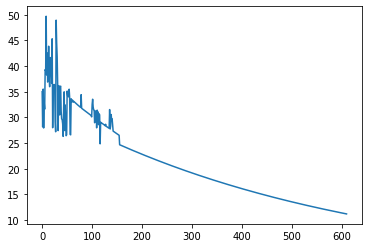

In [1438]:
plt.plot(olg.L[0])

Text(0.5, 1.0, 'wage adjustment')

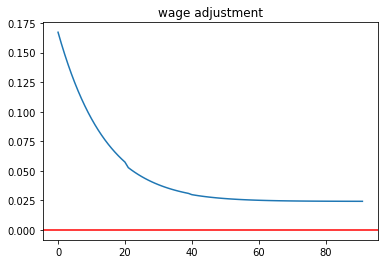

In [1217]:
plt.plot([item[1][6] for i, item in enumerate(olg.steady_path)])
# plt.plot([item[1][1] for i, item in enumerate(olg.steady_path)])
plt.axhline(y=0, color='r', linestyle='-')
plt.title("wage adjustment")

Text(0.5, 1.0, 'Labor')

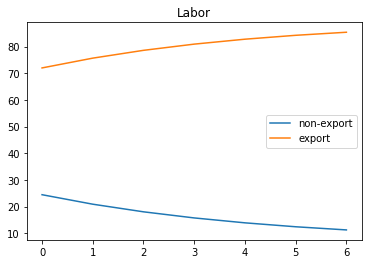

In [1269]:
plt.plot([item[1][1]*item[1][-2] for i, item in enumerate(olg.steady_path)], label = "non-export")
plt.plot([(1-item[1][1])*item[1][-2] for i, item in enumerate(olg.steady_path)], label = "export")
plt.legend()
plt.title("Labor")

Text(0.5, 1.0, 'Capital')

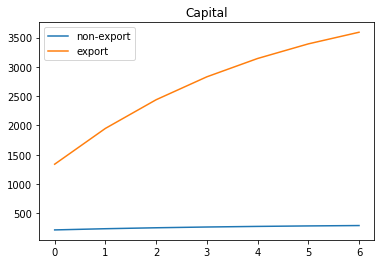

In [1273]:
plt.plot([item[1][0]*item[1][-2] for i, item in enumerate(olg.steady_path)], label = "non-export")
plt.plot([item[1][2]*item[1][-2] for i, item in enumerate(olg.steady_path)], label = "export")
plt.legend()
plt.title("Capital")

Text(0.5, 1.0, 'non-export labor share adjustment')

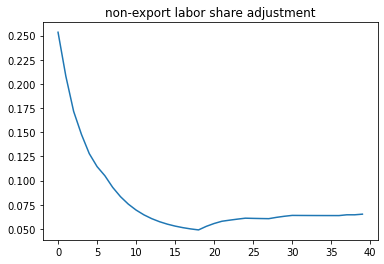

In [1214]:
# plt.plot([item[1][0] for i, item in enumerate(olg.steady_path)])
plt.plot([item[1][1] for i, item in enumerate(olg.steady_path)])
plt.title("non-export labor share adjustment")

Text(0.5, 1.0, 'price adjustment')

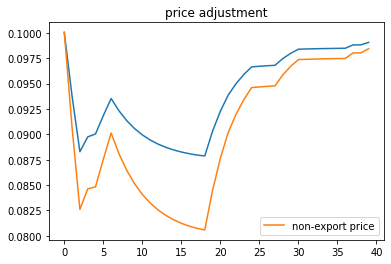

In [1215]:
plt.plot([item[1][4] for i, item in enumerate(olg.steady_path)])
plt.plot([item[1][5] for i, item in enumerate(olg.steady_path)], label ="non-export price")
plt.legend()
plt.title("price adjustment")

Text(0.5, 1.0, 'Target function')

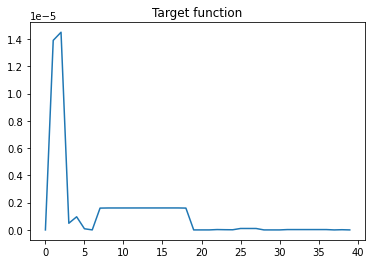

In [1192]:
import matplotlib.pyplot as plt
plt.plot([item[0]["fun"] for i, item in enumerate(olg.steady_path)])
plt.title("Target function")

In [37]:
olg.create_guess()

In [279]:
olg.steady_path[-4]
# единственный выход это потребление тоже менять с eta

(     fun: 497133.5107400712
     info: {'x': array([ 6.50888420e+00,  7.89066419e+02,  3.67245615e+04, -8.85181784e-03,
         2.52521567e+01,  3.05824304e+03,  5.72445545e+04,  3.73356679e-02,
         1.81871797e-01,  2.67263830e-08,  2.11897026e-02]), 'g': array([], dtype=float64), 'obj_val': 497133.5107400712, 'mult_g': array([], dtype=float64), 'mult_x_L': array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]), 'mult_x_U': array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]), 'status': -3, 'status_msg': b'An unrecoverable error occurred while Ipopt tried to compute the search direction.'}
  message: b'An unrecoverable error occurred while Ipopt tried to compute the search direction.'
     nfev: 629
      nit: 21
     njev: 25
   status: -3
  success: False
        x: array([ 6.50888420e+00,  7.89066419e+02,  3.67245615e+04, -8.85181784e-03,
         2.52521567e+01,  3.05824304e+03,  5.72445545e+04,  3.73356679e-02,
         1.81871797e-01,  2.67263830e-08,  2.11897026e-02]),
 array

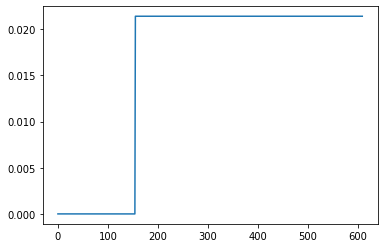

In [38]:
import matplotlib.pyplot as plt
plt.plot(olg.w)

In [39]:
olg.w

array([1.42600744e-05, 1.42507980e-05, 1.42414996e-05, 1.42321791e-05,
       1.42228363e-05, 1.42134710e-05, 1.42040831e-05, 1.41946724e-05,
       1.41852387e-05, 1.41757819e-05, 1.41663018e-05, 1.41567982e-05,
       1.41472709e-05, 1.41377198e-05, 1.41281447e-05, 1.41185453e-05,
       1.41089216e-05, 1.40992733e-05, 1.40896002e-05, 1.40799021e-05,
       1.40701790e-05, 1.40604305e-05, 1.40506564e-05, 1.40408566e-05,
       1.40310309e-05, 1.40211791e-05, 1.40113009e-05, 1.40013962e-05,
       1.39914647e-05, 1.39815062e-05, 1.39715206e-05, 1.39615076e-05,
       1.39514670e-05, 1.39413985e-05, 1.39313020e-05, 1.39211772e-05,
       1.39110239e-05, 1.39008419e-05, 1.38906309e-05, 1.38803907e-05,
       1.38701211e-05, 1.38598218e-05, 1.38494926e-05, 1.38391332e-05,
       1.38287434e-05, 1.38183229e-05, 1.38078715e-05, 1.37973889e-05,
       1.37868749e-05, 1.37763292e-05, 1.37657516e-05, 1.37551417e-05,
       1.37444993e-05, 1.37338241e-05, 1.37231159e-05, 1.37123743e-05,
      

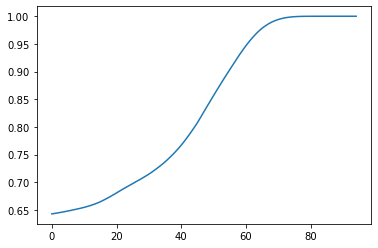

In [606]:
# plt.plot(olg.c[0][345-30,(250-30):(345-30)]) # труд у дрпугих неправильно рассчитывается?
# plt.plot(olg.l[0][345-30,(250-30):(345-30)])


In [43]:
olg.w[99]

1.3201810425347083e-05

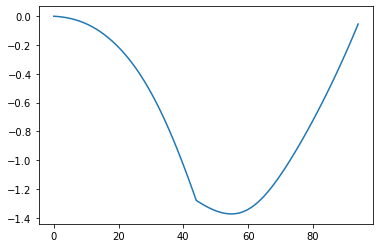

In [25]:
# plt.plot(olg.l[0][260,165:260], label= "labor")
# plt.plot(olg.c[0][260,165:260], label = "consumption")
plt.plot(olg.a[0][260,165:260], label = "assets")
# plt.plot((olg.c[0][260,165:260]**olg.phi * (1-olg.l[0][260,165:260])**(1-olg.phi))**(1-olg.theta)/(1-olg.theta), label = "utility")
plt.show()

Text(0.5, 1.0, 'Wage path')

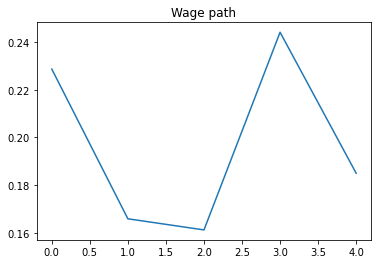

In [614]:
plt.plot([item[0]["info"]["x"][8] for i, item in enumerate(olg.steady_path)if i != 1] [0:])
plt.title("Wage path")

Text(0.5, 1.0, 'Price N path')

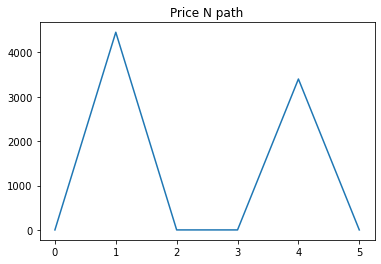

In [615]:
plt.plot([item[0]["info"]["x"][10] for item in olg.steady_path][0:])
plt.title("Price N path")

In [470]:
for _ in range(1):
    olg.update_guess()

IndexError: too many indices for array: array is 1-dimensional, but 2 were indexed

In [ ]:
import matplotlib.pyplot as plt
# plt.plot((((olg.c[:,:610,:]*olg.N[:,:610,:]).sum(axis=0).sum(axis=0))/olg.N[:,:610,:].sum(axis=0).sum(axis=0))[:150])
# plt.plot((((olg.a[:,:610,:]*olg.N[:,:610,:]).sum(axis=0).sum(axis=0))/olg.N[:,:610,:].sum(axis=0).sum(axis=0))[:150])
plt.plot((((olg.l[:,:610,:]*olg.N[:,:610,:]).sum(axis=0).sum(axis=0))/olg.N[:,:610,:].sum(axis=0).sum(axis=0))[:250])
# plt.plot(olg.I[0,:100]/olg.N[0].sum(axis=0)[:100])
# plt.plot((olg.l[0,:250]*olg.N[0,:250]).sum(axis=0)/(olg.N[0,:250].sum(axis=0)))
plt.show()

In [ ]:
plt.plot(olg.I[0,1:100]/olg.I[0,0:99])

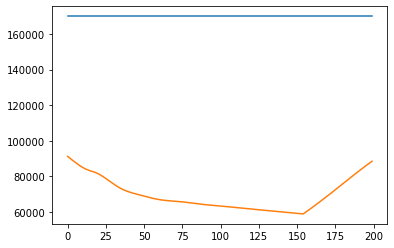

In [616]:
plt.plot(olg.L[0][:200]+olg.L[1][:200])
plt.plot(((olg.l[:,:610,:]*olg.N[:,:610,:]*olg.epsilon[:,:610,:]).sum(axis=0).sum(axis=0))[:200])

In [331]:
olg.L[0][:200]+olg.L[1][:200]

array([170000., 170000., 170000., 170000., 170000., 170000., 170000.,
       170000., 170000., 170000., 170000., 170000., 170000., 170000.,
       170000., 170000., 170000., 170000., 170000., 170000., 170000.,
       170000., 170000., 170000., 170000., 170000., 170000., 170000.,
       170000., 170000., 170000., 170000., 170000., 170000., 170000.,
       170000., 170000., 170000., 170000., 170000., 170000., 170000.,
       170000., 170000., 170000., 170000., 170000., 170000., 170000.,
       170000., 170000., 170000., 170000., 170000., 170000., 170000.,
       170000., 170000., 170000., 170000., 170000., 170000., 170000.,
       170000., 170000., 170000., 170000., 170000., 170000., 170000.,
       170000., 170000., 170000., 170000., 170000., 170000., 170000.,
       170000., 170000., 170000., 170000., 170000., 170000., 170000.,
       170000., 170000., 170000., 170000., 170000., 170000., 170000.,
       170000., 170000., 170000., 170000., 170000., 170000., 170000.,
       170000., 1700

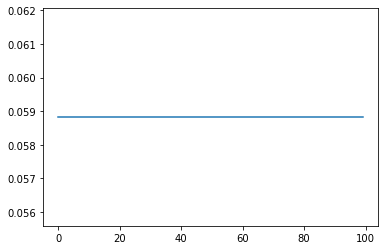

In [332]:
plt.plot((olg.K[0]/olg.L[0])[:100])

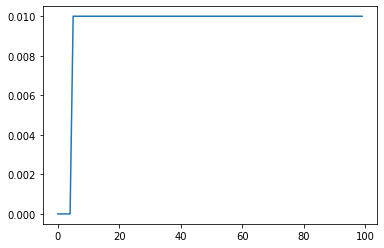

In [44]:
plt.plot(olg.a[0][100][:100])

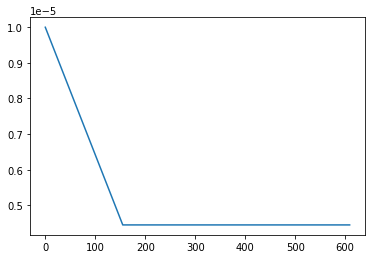

In [45]:
plt.plot(olg.price_N)

In [54]:
olg.w[120]

1.2925927310610548e-05

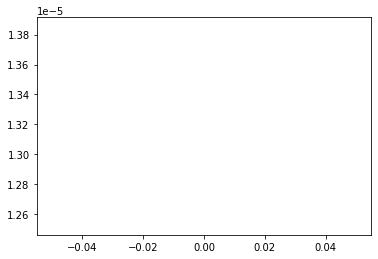

In [49]:
plt.plot(olg.w[100])